# Wind Turbine Location Prediction Model

This notebook builds a machine learning model to predict whether a location (from NREL's Wind Toolkit) has a wind turbine based on various features. The workflow includes:

1. **Data Loading**: Loading USWTDB (wind turbine database) and NREL WTK (Wind Toolkit) data
2. **Spatial Matching**: Using geospatial joins to match turbines to NREL grid cells
3. **Feature Engineering**: Preparing features for machine learning
4. **Model Training**: Training a logistic regression classifier
5. **Model Evaluation**: Evaluating and saving the trained model


## 1. Import Required Libraries

Import the necessary libraries for data manipulation, machine learning, and model evaluation.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

## 2. Load and Preprocess USWTDB Data

Load the US Wind Turbine Database (USWTDB) which contains information about existing wind turbines. We round the longitude and latitude coordinates to 3 decimal places to match the precision of the NREL dataset for spatial matching.


Changing column names and rounding of USWTDB to match NREL datasite

## 3. Load and Preprocess NREL WTK Data

Load the NREL Wind Toolkit (WTK) site metadata which contains grid cell locations and wind resource data. Similar to the USWTDB data, we round coordinates to 3 decimal places for spatial matching.


In [ ]:
uswtdb = pd.read_csv('../datasets/uswtdb_V8_1_20250522.csv')
uswtdb['long_rounded'] = uswtdb['xlong'].round(3)
uswtdb['lat_rounded'] = uswtdb['ylat'].round(3)
uswtdb.head()

,case_id,faa_ors,faa_asn,usgs_pr_id,eia_id,t_state,t_county,t_fips,p_name,p_year,...,t_retro_yr,t_offshore,t_conf_atr,t_conf_loc,t_img_date,t_img_src,xlong,ylat,longtude,latitude
0,3119490,40-097498,2021-WTW-7911-OE,NaN,65511.0,OK,Ellis County,40045.0,25 Mile Creek,2022.0,...,NaN,0,3,3,1/4/2023,Maxar,-99.741096,36.423683,-99.7411,36.4237
1,3124158,40-098166,2021-WTW-7917-OE,NaN,65511.0,OK,Ellis County,40045.0,25 Mile Creek,2022.0,...,NaN,0,3,3,1/4/2023,Maxar,-99.796494,36.503357,-99.7965,36.5034
2,3123358,40-098173,2021-WTW-7871-OE,NaN,65511.0,OK,Ellis County,40045.0,25 Mile Creek,2022.0,...,NaN,0,3,3,1/4/2023,Maxar,-99.741119,36.502590,-99.7411,36.5026
3,3123761,40-097539,2021-WTW-7888-OE,NaN,65511.0,OK,Ellis County,40045.0,25 Mile Creek,2022.0,...,NaN,0,3,3,1/4/2023,Maxar,-99.771027,36.456665,-99.7710,36.4567
4,3124023,40-097763,2021-WTW-7894-OE,NaN,65511.0,OK,Ellis County,40045.0,25 Mile Creek,2022.0,...,NaN,0,3,3,1/4/2023,Maxar,-99.775742,36.445465,-99.7757,36.4455


## 4. Spatial Join: Matching Turbines to NREL Grid Cells

This section performs a spatial nearest-neighbor join to match each wind turbine from the USWTDB to its nearest NREL WTK grid cell. This allows us to:
- Identify which NREL grid cells have turbines (positive examples)
- Identify which NREL grid cells don't have turbines (negative examples)

**Key steps:**
1. Install and import geopandas for geospatial operations
2. Convert dataframes to GeoDataFrames with point geometries
3. Transform coordinates to a projected CRS (EPSG:3857) for accurate distance calculations in meters
4. Perform nearest-neighbor spatial join with a maximum distance cap of 25 km
5. Create a match indicator and save the joined dataset


Changing column names and rounding of USWTDB to match NREL datasite

## 5. Load Joined Data and Prepare Labels

Load the spatially joined dataset and rename the `match_ok` column to `isTurbine` to create a binary label indicating whether a turbine exists at that location.


In [ ]:
nrel = pd.read_csv('../datasets/wtk_site_metadata.csv')
nrel['long_rounded'] = nrel['longitude'].round(3)
nrel['lat_rounded'] = nrel['latitude'].round(3)
nrel.head()


,site_id,longitude,latitude,State,County,fraction_of_usable_area,power_curve,capacity,wind_speed,capacity_factor,full_timeseries_directory,full_timeseries_path,long_rounded,lat_rounded
0,0,-117.147260,23.510410,Unknown,Unknown,1.0,offshore,16,6.07,0.169,0,0/0.nc,-117.1473,23.5104
1,1,-93.946777,24.007446,Unknown,Unknown,1.0,offshore,16,7.43,0.302,0,0/1.nc,-93.9468,24.0074
2,2,-97.482483,25.069138,Unknown,Unknown,1.0,offshore,16,8.19,0.375,0,0/2.nc,-97.4825,25.0691
3,3,-97.463135,25.069443,Unknown,Unknown,1.0,offshore,16,8.19,0.375,0,0/3.nc,-97.4631,25.0694
4,4,-97.443756,25.069763,Unknown,Unknown,1.0,offshore,16,8.19,0.376,0,0/4.nc,-97.4438,25.0698


### Check Column Names

Verify the columns in the joined dataset to ensure data structure is correct.


# Use spatial nearest-neighbor joins to assign each USWTDB wind turbine to its nearest NREL WTK grid cell
# Used geopandas to fo nearest-neighbor joins


## 6. Create Training Dataset

Merge the NREL site metadata with the turbine labels (`isTurbine`) to create the training dataset. This dataset will be used to train the machine learning model.

**Process:**
- Merge NREL data with turbine labels based on `site_id`
- Fill missing values in `isTurbine` with `False` (locations without turbines)
- Remove the `power_curve` column (not needed for this model)
- Save the prepared training data to CSV


In [ ]:
%pip install geopandas

import geopandas as gpd
from shapely.geometry import Point

# Build geometry columns
g_uswtdb = gpd.GeoDataFrame(
    uswtdb,
    geometry=gpd.points_from_xy(uswtdb.xlong, uswtdb.ylat),
    crs="EPSG:4326"
)

g_nrel = gpd.GeoDataFrame(
    nrel,
    geometry=gpd.points_from_xy(nrel.longitude, nrel.latitude),
    crs="EPSG:4326"
)

g_uswtdb_m = g_uswtdb.to_crs(3857)
g_nrel_m = g_nrel.to_crs(3857)

# 4) One tolerance for everyone (tune this after inspecting a distance histogram)
MAX_DIST_M = 25000  # 25 km

# 5) Nearest-neighbor spatial join with a distance cap

joined_m = gpd.sjoin_nearest(
    g_uswtdb_m,
    g_nrel_m[[
        "geometry",
        "site_id",
        "longitude",
        "latitude",
        "State",
        "County",
        "fraction_of_usable_area",
        "power_curve",
        "capacity",
        "wind_speed",
        "capacity_factor",
        "full_timeseries_directory",
        "full_timeseries_path"
    ]],
    how="left",
    distance_col="dist_m",
    max_distance=MAX_DIST_M,
)


joined_m["match_ok"] = joined_m["site_id"].notna()

joined_m.to_csv("../datasets/uswt_nrel_joined.csv", index=False)

Note: you may need to restart the kernel to use updated packages.


### Explore Data Distribution

Check the distribution of counties in the training data to understand the geographic coverage.


In [ ]:
uswtdb_nrel_joined = pd.read_csv("../datasets/uswt_nrel_joined_match.csv")

## 7. Prepare Features and Target Variable

Load the training data and select the features that will be used to predict turbine presence:

- **fraction_of_usable_area**: Fraction of the grid cell that is usable for wind development
- **capacity**: Potential capacity of the site
- **wind_speed**: Average wind speed at the site
- **capacity_factor**: Expected capacity factor (efficiency)

The target variable `isTurbine` indicates whether a turbine exists at that location (True/False).


In [9]:
uswtdb_nrel_joined.rename(columns={"match_ok": "isTurbine"}, inplace=True)

### Inspect Feature Data

Preview the feature matrix to verify the data structure.


In [14]:
uswtdb_nrel_joined.columns

Index(['case_id', 'faa_ors', 'faa_asn', 'usgs_pr_id', 'eia_id', 't_state',
       't_county', 't_fips', 'p_name', 'p_year', 'p_tnum', 'p_cap', 't_manu',
       't_model', 't_cap', 't_hh', 't_rd', 't_rsa', 't_ttlh', 't_retrofit',
       't_retro_yr', 't_offshore', 't_conf_atr', 't_conf_loc', 't_img_date',
       't_img_src', 'xlong', 'ylat', 'longtude', 'latitude_left', 'geometry',
       'index_right', 'site_id', 'longitude', 'latitude_right', 'State',
       'County', 'fraction_of_usable_area', 'power_curve', 'capacity',
       'wind_speed', 'capacity_factor', 'full_timeseries_directory',
       'full_timeseries_path', 'dist_m', 'isTurbine'],
      dtype='object')

## 8. Split Data into Training and Testing Sets

Split the data into training (80%) and testing (20%) sets. Using stratified sampling ensures that both sets have similar proportions of turbine and non-turbine locations, which is important for imbalanced datasets.


In [ ]:
nrel = pd.read_csv('../datasets/wtk_site_metadata.csv')
uswtdb = pd.read_csv('../datasets/uswtdb_V8_1_20250522.csv')
training_data = nrel.merge(
    uswtdb_nrel_joined[['site_id', 'isTurbine']],
    on='site_id',
    how='left'
)

training_data['isTurbine'].fillna(False, inplace=True)
training_data = training_data.drop(columns=['power_curve'])
training_data.to_csv('../datasets/nrel_training_data.csv', index=False)

C:\Users\bemne\AppData\Local\Temp\ipykernel_98808\1036386332.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  training_data['isTurbine'].fillna(False, inplace=True)
C:\Users\bemne\AppData\Local\Temp\ipykernel_98808\1036386332.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  training_data['isTurbine'].fill

## 9. Scale Features

Standardize the features using StandardScaler. This is important for logistic regression because:
- Features are on different scales (e.g., capacity vs. wind_speed)
- Logistic regression is sensitive to feature scaling
- Standardization improves convergence and model performance


In [3]:
training_data = pd.read_csv("../datasets/nrel_training_data.csv")

## 10. Train Logistic Regression Model

Train a logistic regression classifier with the following settings:
- **max_iter=1000**: Maximum iterations for convergence
- **class_weight="balanced"**: Automatically adjust weights to handle class imbalance (more non-turbine locations than turbine locations)
- **n_jobs=-1**: Use all available CPU cores for faster training

After training, evaluate the model on the test set using:
- **ROC-AUC score**: Measures the model's ability to distinguish between classes
- **Classification report**: Provides precision, recall, and F1-score for each class


## 11. Save Model and Scaler

Save the trained model and scaler to disk so they can be loaded later for making predictions on new data. The scaler is essential because new data must be transformed using the same scaling parameters used during training.


In [4]:
training_data = pd.read_csv('../datasets/nrel_training_data.csv')

## 12. Save Model Metrics

Save the model evaluation metrics (ROC-AUC score and classification report) to a JSON file for record-keeping and future reference.


In [5]:
X = training_data[[
    "fraction_of_usable_area",
    "capacity",
    "wind_speed",
    "capacity_factor"
]]
y = training_data['isTurbine']

In [6]:
X.head()

,fraction_of_usable_area,capacity,wind_speed,capacity_factor
0,1.0,16,6.07,0.169
1,1.0,16,7.43,0.302
2,1.0,16,8.19,0.375
3,1.0,16,8.19,0.375
4,1.0,16,8.19,0.376


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [ ]:
#Scale features (logistic regression needs this)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",  # helps with imbalance
    n_jobs=-1
)
log_reg.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)

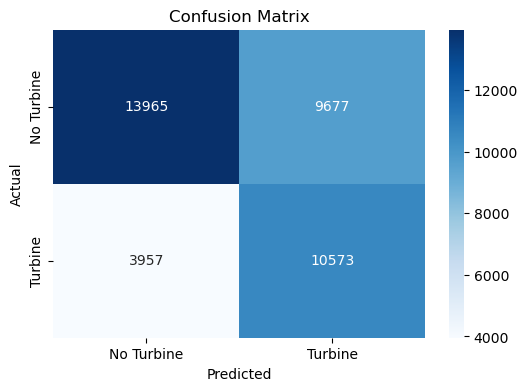

ROC-AUC: 0.7318750421011098
              precision    recall  f1-score   support

       False      0.779     0.591     0.672     23642
        True      0.522     0.728     0.608     14530

    accuracy                          0.643     38172
   macro avg      0.651     0.659     0.640     38172
weighted avg      0.681     0.643     0.648     38172



In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Turbine", "Turbine"], yticklabels=["No Turbine", "Turbine"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred, digits=3))

In [12]:
import joblib

# Save the model
joblib.dump(log_reg, "logistic_regression_wind_model.pkl")

# Save the scaler (needed to transform future data the same way)
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [80]:
import json

metrics = {
    "model": "logistic_regression",
    "roc_auc": roc_auc_score(y_test, y_prob),
    "classification_report": classification_report(y_test, y_pred, digits=3, output_dict=True)
}

with open("model_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

print("AUC saved to model_metrics.json")

AUC saved to model_metrics.json
